In [23]:
import regulus
from regulus import Circuit, gates
import cirq
import qiskit.converters as qiskit_convert


### Qubit mapping

In [50]:
import qiskit
import pytket

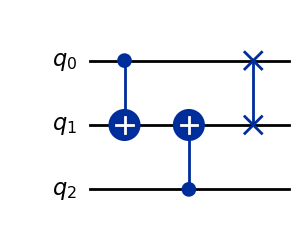

In [79]:
circ = Circuit([
    gates.X.on(1, 0),
    gates.X.on(1, 2),
    gates.SWAP.on([0,1]),
    # gates.T.on(0), gates.T.on(1), gates.T.on(2),
    # gates.RXX(0.1).on([0,1]),
    # gates.RZZ(0.1).on([1,2]),


    # gates.Can(0.1, 0.2, 0.3).on([0,1]),
    # gates.Can(0.1, 0.2, 0.3).on([1,2]),
])

circ.to_qiskit().draw('mpl')

In [81]:
def qiskit_O3_all2all(circ: qiskit.QuantumCircuit) -> qiskit.QuantumCircuit:
    from itertools import combinations
    for q0, q1 in combinations(range(circ.num_qubits), 2):
        circ.cx(q0, q1)
        circ.cx(q0, q1)
    circ = qiskit.transpile(circ, optimization_level=3, basis_gates=['u1', 'u2', 'u3', 'cx'])
    return circ

def tket_pass(circ: pytket.Circuit) -> pytket.Circuit:

    pytket.passes.FullPeepholeOptimise(allow_swaps=False).apply(circ)

    return circ

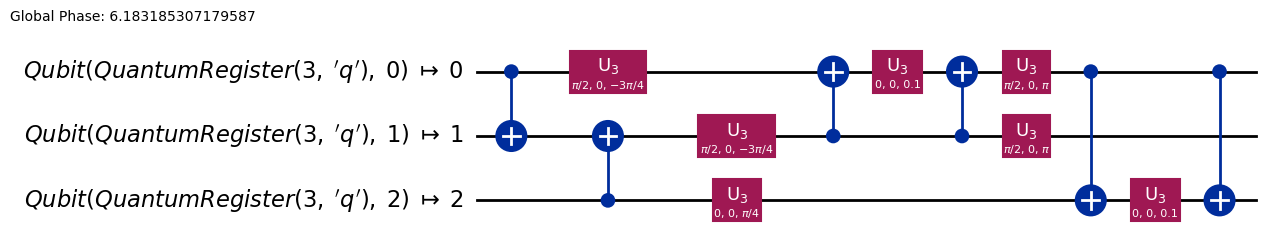

In [73]:
qiskit.transpile(circ.to_qiskit(), optimization_level=3, basis_gates=['u3', 'cx']).draw('mpl')

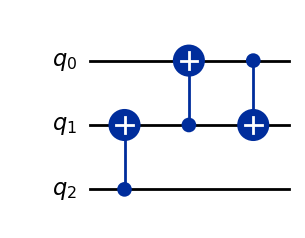

In [82]:
Circuit.from_tket(tket_pass(circ.to_tket())).to_qiskit().draw('mpl')

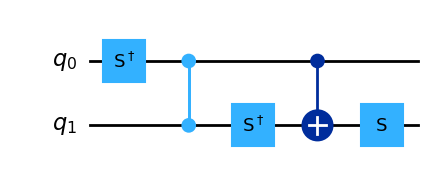

In [86]:
cnot_circ = Circuit([
    gates.SDG.on(0),
    gates.Z.on(1, 0), 
    gates.SDG.on(1),
    gates.X.on(1, 0), 
    gates.S.on(1),
])
cnot_circ.to_qiskit().draw('mpl')

In [115]:
circ = Circuit([
    gates.H.on(0), gates.H.on(2), gates.H.on(5),
    gates.Z.on(0),
    # gates.I.on(0), gates.I.on(0), gates.I.on(0), gates.I.on(0), gates.I.on(0),
    gates.X.on(2, 1), gates.X.on(5, 4),
    gates.X.on(1, 0), gates.X.on(3, 2),
    gates.H.on(2), gates.H.on(3),
    gates.X.on(2, 1), gates.X.on(5, 3),
    gates.Z.on(3),
    gates.X.on(3, 4),
    gates.X.on(0, 3)
])

from qiskit.transpiler import CouplingMap
from typing import List, Tuple

def sabre_map(circ: qiskit.QuantumCircuit, coupling_map: CouplingMap) -> Tuple[
    qiskit.QuantumCircuit, List[int], List[int]]:
    """
    Mapping logical circuits on physical qubits by means of SabreLayout pass in Qiskit.

    Args:
        circ: Input logical quantum circuit
        coupling_map: Physical qubit connectivity graph

    Returns:
        Mapped circuit, initial mapping (physical qubit indices), final mapping (physical qubit indices)
    """
    from qiskit.transpiler import passes
    from qiskit.transpiler import PassManager

    pm = PassManager([passes.SabreLayout(coupling_map)])
    circ = pm.run(circ)
    # print(circ.layout.initial_index_layout(), circ.layout.final_index_layout())
    return circ


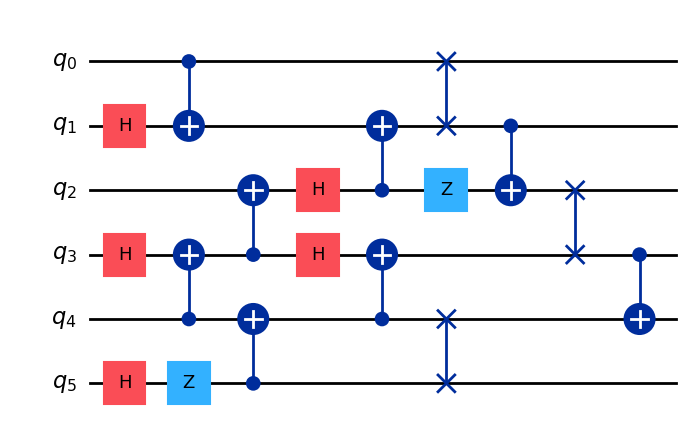

In [118]:
new_circ = Circuit.from_qiskit(sabre_map(circ.to_qiskit(), CouplingMap.from_line(6)))
new_circ.to_qiskit().draw('mpl')

100%|██████████| 10/10 [00:00<00:00, 509.76it/s]

{0: 3, 1: 0, 2: 1, 3: 2, 4: 5, 5: 4}
{0: 3, 1: 1, 2: 0, 3: 4, 4: 5, 5: 2}


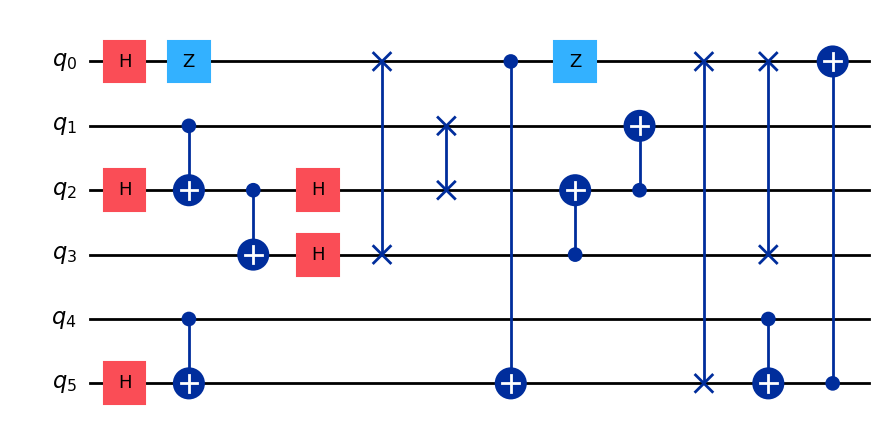

In [145]:
from regulus.transforms import mirror
import rustworkx as rx

new_circ_reg, init_mapping, final_mapping = mirror.mirror_with_sabre(circ, rx.generators.path_graph(6))
print(init_mapping)
print(final_mapping)

new_circ_reg.to_qiskit().draw('mpl')

In [80]:
circ.to_qiskit().draw()


q_0: ──■────────X─
     ┌─┴─┐┌───┐ │ 
q_1: ┤ X ├┤ X ├─X─
     └───┘└─┬─┘   
q_2: ───────■─────

In [102]:
c = cirq.Circuit(cirq.QubitPermutationGate([0,3,2,4,1]).on(*cirq.LineQubit.range(5)))

cirq.Circuit(cirq.decompose(c))


┌──────┐
1: ────────────@───Y^-0.5───@───Y^0.5────@─────────@────Y^-0.5───@───Y^0.5────@───────────
               │            │            │         │             │            │
3: ───Y^-0.5───@───Y^0.5────@───Y^-0.5───@────Y^0.5┼─────────────┼────────────┼───────────
                                                   │             │            │
4: ───Y^-0.5───────────────────────────────────────@────Y^0.5────@───Y^-0.5───@───Y^0.5───
                                             └──────┘